In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from surprise import dump
_, nmf = dump.load(PROCESSED/'nmf.dump')

In [4]:
week_labels = [20180226, 20180305, 20180312, 20180319, 
               20180326, 20180402, 20180409, 20180416, 20180423]

In [15]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather'))

CPU times: user 5.53 s, sys: 3.21 s, total: 8.74 s
Wall time: 16.3 s


## NMF features

In [6]:
uid = nmf.trainset._raw2inner_id_users
iid = nmf.trainset._raw2inner_id_items

In [16]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
for w in weeks:
    w['NMF_CustomerBias'] = [nmf.bu[uid[x]] for x in w.CustomerIdx]
    w['NMF_IsinBias'] = [nmf.bi[iid[x]] for x in w.IsinIdx]
    w['NMF_Recommend'] = [nmf.predict(cIdx, iIdx).est for cIdx, iIdx in zip(w.CustomerIdx, w.IsinIdx)]

CPU times: user 26.8 s, sys: 776 ms, total: 27.6 s
Wall time: 27.2 s


In [17]:
%%time
for n, w in zip(week_labels, weeks):
    customer_factors = np.array([nmf.pu[uid[cIdx]] for cIdx in w.CustomerIdx])
    isin_factors = np.array([nmf.qi[iid[iIdx]] for iIdx in w.IsinIdx])
    for i in range(customer_factors.shape[1]):
        w[f'NMF_CustomerFactor{i:02}'] = customer_factors[:,i]
    for i in range(isin_factors.shape[1]):
        w[f'NMF_IsinFactor{i:02}'] = isin_factors[:,i]

CPU times: user 6.96 s, sys: 860 ms, total: 7.82 s
Wall time: 7.82 s


## Preprocessing

In [19]:
from functools import cmp_to_key
from src.utils import composite_rating_cmp
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
ratings = list(isin.CompositeRating.value_counts().index)
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [20]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    w['CompositeRating']  = w.CompositeRating.apply(lambda x: rank[x])

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 2.55 s, sys: 168 ms, total: 2.72 s
Wall time: 2.75 s


In [21]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [22]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [23]:
%%time
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

CPU times: user 13.5 s, sys: 860 ms, total: 14.4 s
Wall time: 15.5 s


## Model

In [24]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [25]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [26]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], weeks[-2], weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=100),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=100',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=False)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.600404
[2]	valid_0's auc: 0.602325
[3]	valid_0's auc: 0.602604
[4]	valid_0's auc: 0.605043
[5]	valid_0's auc: 0.606338
[6]	valid_0's auc: 0.609871
[7]	valid_0's auc: 0.611764
[8]	valid_0's auc: 0.611535
[9]	valid_0's auc: 0.609489
[10]	valid_0's auc: 0.614098
[11]	valid_0's auc: 0.61323
[12]	valid_0's auc: 0.613914
[13]	valid_0's auc: 0.616639
[14]	valid_0's auc: 0.617119
[15]	valid_0's auc: 0.616802
[16]	valid_0's auc: 0.61878
[17]	valid_0's auc: 0.617282
[18]	valid_0's auc: 0.61688
[19]	valid_0's auc: 0.614923
[20]	valid_0's auc: 0.617826
[21]	valid_0's auc: 0.618108
[22]	valid_0's auc: 0.621957
[23]	valid_0's auc: 0.621999
[24]	valid_0's auc: 0.621892
[25]	valid_0's auc: 0.621403
[26]	valid_0's auc: 0.620909
[27]	valid_0's auc: 0.621119
[28]	valid_0's auc: 0.621901
[29]	valid_0's auc: 0.621396
[30]	valid_0's auc: 0.618571
[31]	valid_0's auc: 0.61874
[32]	valid_0's auc: 0.618073
[33]	valid_0's auc: 0.615581
[34]	valid_0's auc: 0.615586
[35]	valid

In [27]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=100,13.81,0.824051,0.615552
1,20180305_diffcounts,LGBMClassifier,n_estimators=100,10.25,0.802160,0.657165
2,20180312_diffcounts,LGBMClassifier,n_estimators=100,10.07,0.799314,0.687103
3,20180319_diffcounts,LGBMClassifier,n_estimators=100,10.10,0.816182,0.696283
4,20180326_diffcounts,LGBMClassifier,n_estimators=100,12.57,0.843522,0.674410
5,20180402_diffcounts,LGBMClassifier,n_estimators=100,11.20,0.831654,0.735788
6,20180409_diffcounts,LGBMClassifier,n_estimators=100,11.19,0.835983,0.770003
7,20180416_diffcounts,LGBMClassifier,n_estimators=100,11.16,0.843515,0.843515


In [28]:
# first 5 predictions (2018 data)
np.array([x[0] for x in output])[:,:5]

array([[0.05777068, 0.17136324, 0.02398125, 0.01103477, 0.01572915],
       [0.05987889, 0.13925944, 0.0240458 , 0.04302091, 0.02054361],
       [0.03616538, 0.07996996, 0.02688976, 0.04008756, 0.02259366],
       [0.02774137, 0.06537953, 0.03289048, 0.01342498, 0.01652126],
       [0.03343043, 0.09209332, 0.02115331, 0.06895432, 0.01697444],
       [0.05155522, 0.11608759, 0.03988583, 0.03681602, 0.02281154],
       [0.07135033, 0.10303131, 0.02743129, 0.02879186, 0.02998875],
       [0.04272043, 0.04718856, 0.0401054 , 0.03350971, 0.04135082]])

In [29]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

## Submission

In [30]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [31]:
submission[target_col].describe()

count    484758.000000
mean          0.029857
std           0.031436
min           0.002904
25%           0.012892
50%           0.023319
75%           0.037433
max           0.866396
Name: CustomerInterest, dtype: float64

In [32]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.047577
1,c2cc6cc2a8,0.101797
2,a8e94f6344,0.029548
3,758bae1e35,0.034455
4,02ab378ee8,0.023314


In [33]:
submission.to_csv(SUBMISSIONS/'18-lgbm_8weeks_NMF_diffscounts_0226-0416.csv', index=False)

In [ ]:
!kaggle competitions submit -c DSG2018-qualifiers -f {SUBMISSIONS/'18-lgbm_8weeks_NMF_diffscounts_0226-0416.csv'} -m "RA: 8 weeks + diffscounts + NMF features (15 factors + bias + rating)"

## Feature importance

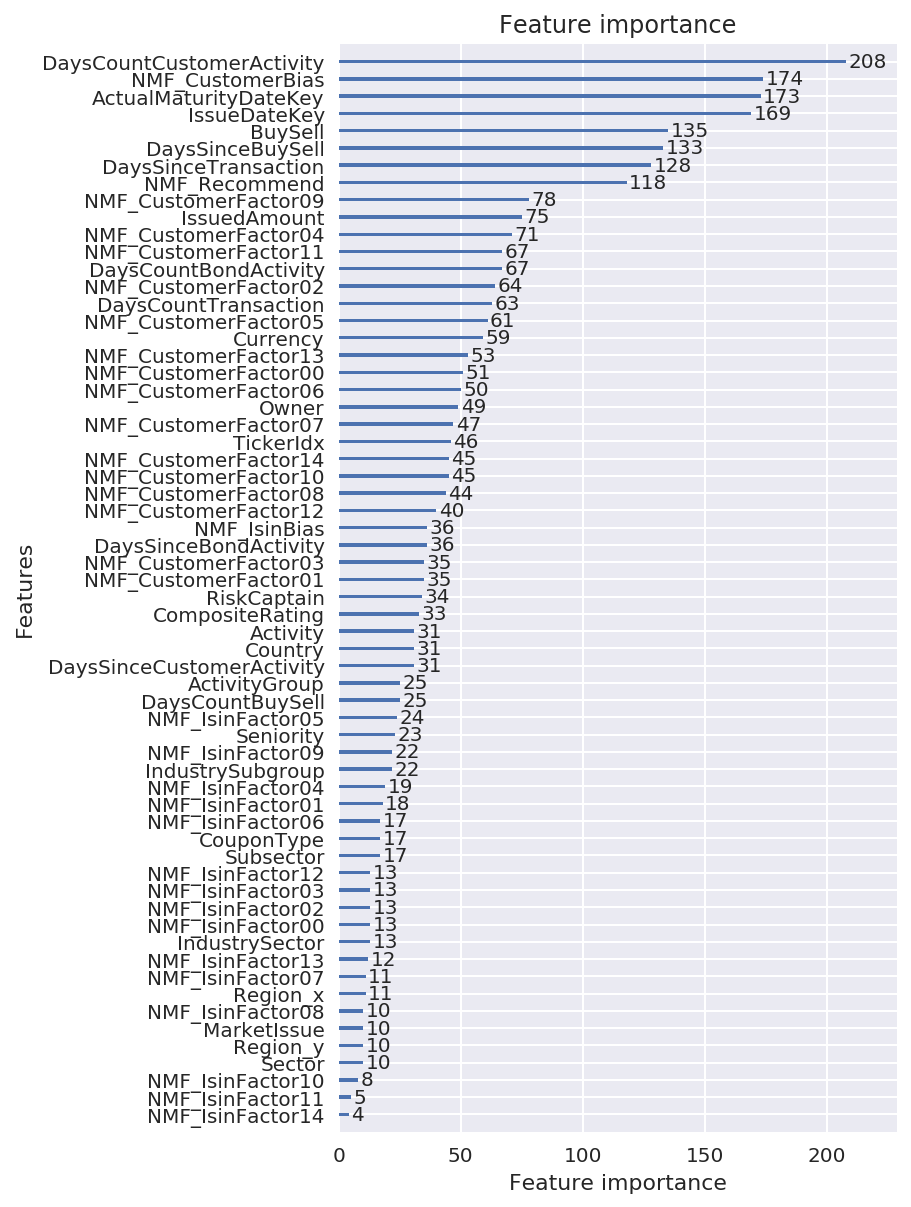

In [34]:
from lightgbm import plot_importance
plot_importance(output[0][1], figsize=(5,10))

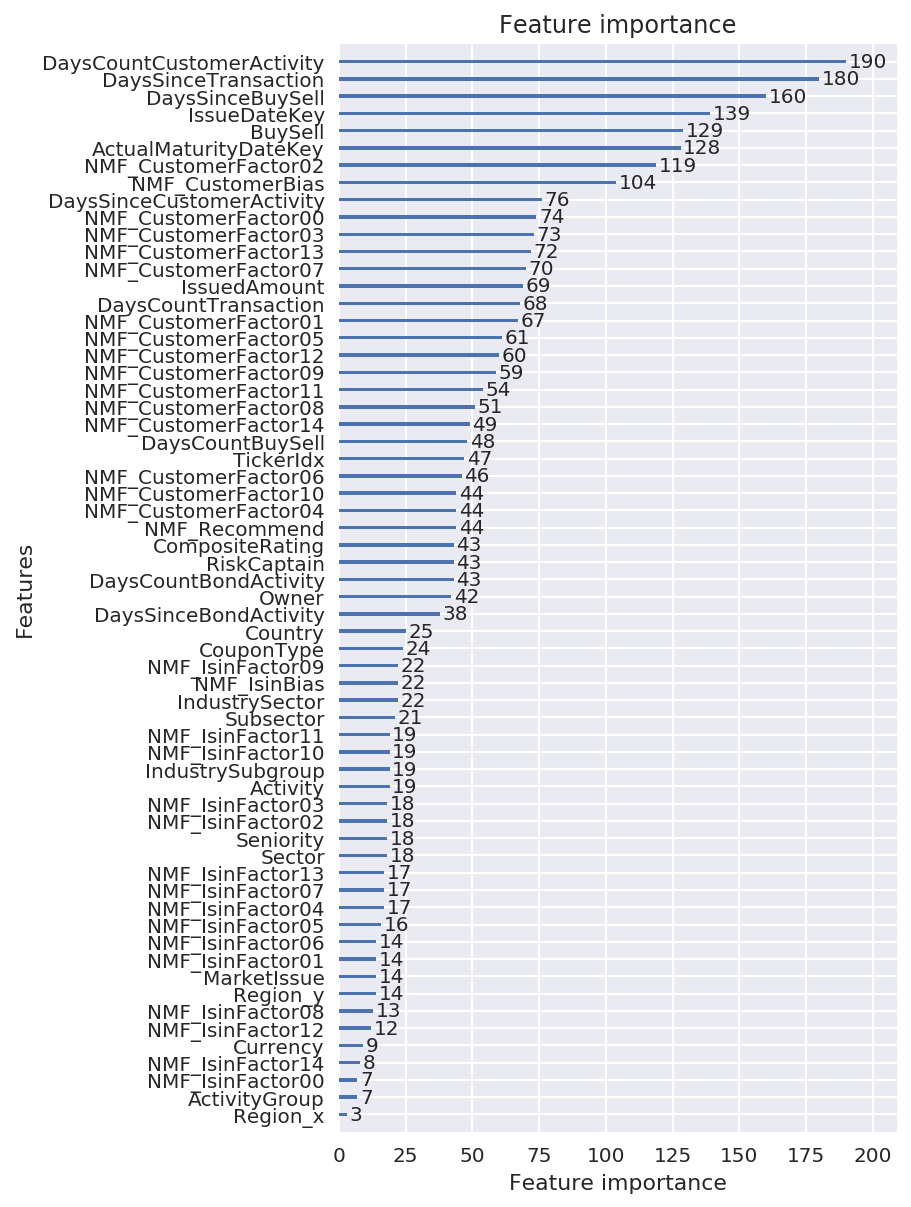

In [35]:
plot_importance(output[-1][1], figsize=(5,10))